# i2b2 tranSMART working session - Boston, MA.
## 260 Longwood Ave - Tosteson Medical Education Center
## TMEC rooms 306 and TMEC L-007
### Thursday, June 28th

# Hail Demo

<img src="https://hail.is/docs/devel/hail-logo-cropped.png" width= "150px">

## Documentation:

https://hail.is/

https://hail.is/docs/devel/tutorials/01-genome-wide-association-study.html#Check-for-tutorial-data-or-download-if-necessary

In [1]:
# Install Hail environment
import hail as hl
import hail.expr.aggregators as agg
hl.init()

Running on Apache Spark version 2.2.1
SparkUI available at http://10.128.0.7:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version devel-aa83f2a1d041
NOTE: This is a beta version. Interfaces may change
  during the beta period. We recommend pulling
  the latest changes weekly.


## Import Matrix Table file

In [2]:
# about 1.2TB data
vds = hl.read_matrix_table("gs://1k-genome/1000-genomes/VDS-of-all/ALL.chr.integrated_phase1_v3.20101123.snps_indels_svs.genotypes.mt")

## Getting to know our data 

### Describe the data

In [3]:
#size of the matrix
vds.count()

(39706715, 1092)

In [4]:
#number of colomns
vds.count_cols()

1092

In [5]:
#number of rows 
vds.count_rows()

39706715

In [6]:
vds.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Column fields:
    's': str 
----------------------------------------
Row fields:
    'locus': locus<GRCh37> 
    'alleles': array<str> 
    'rsid': str 
    'qual': float64 
    'filters': set<str> 
    'info': struct {
        LDAF: float64, 
        AVGPOST: float64, 
        RSQ: float64, 
        ERATE: float64, 
        THETA: float64, 
        CIEND: array<int32>, 
        CIPOS: array<int32>, 
        END: int32, 
        HOMLEN: array<int32>, 
        HOMSEQ: array<str>, 
        SVLEN: int32, 
        SVTYPE: str, 
        AC: array<int32>, 
        AN: int32, 
        AA: str, 
        AF: array<float64>, 
        AMR_AF: float64, 
        ASN_AF: float64, 
        AFR_AF: float64, 
        EUR_AF: float64, 
        VT: str, 
        SNPSOURCE: array<str>
    } 
----------------------------------------
Entry fields:
    'GT': call 
    'DS': float64 
    'GL': array<floa

In [7]:
list(vds.row)

['locus', 'alleles', 'rsid', 'qual', 'filters', 'info']

### See the data in more detail

In [8]:
# see the variants
vds.rows().show(3)

+---------------+------------+-------------+-------------+----------+-------------+
| locus         | alleles    | rsid        |        qual | filters  |   info.LDAF |
+---------------+------------+-------------+-------------+----------+-------------+
| locus<GRCh37> | array<str> | str         |     float64 | set<str> |     float64 |
+---------------+------------+-------------+-------------+----------+-------------+
| 1:10583       | ["G","A"]  | rs58108140  | 1.00000e+02 | []       | 2.32700e-01 |
| 1:10611       | ["C","G"]  | rs189107123 | 1.00000e+02 | []       | 4.79000e-02 |
| 1:13302       | ["C","T"]  | rs180734498 | 1.00000e+02 | []       | 1.57300e-01 |
+---------------+------------+-------------+-------------+----------+-------------+

+--------------+-------------+-------------+-------------+--------------+
| info.AVGPOST |    info.RSQ |  info.ERATE |  info.THETA | info.CIEND   |
+--------------+-------------+-------------+-------------+--------------+
|      float64 |     

In [7]:
# Display the samples
vds.s.show(5)

+---------+
| s       |
+---------+
| str     |
+---------+
| HG00096 |
| HG00097 |
| HG00099 |
| HG00100 |
| HG00101 |
+---------+
showing top 5 rows



In [16]:
samples = vds.s.take(1091)

### Find additional details regarding variant calls and genotype information here: 
https://gatkforums.broadinstitute.org/gatk/discussion/1268/what-is-a-vcf-and-how-should-i-interpret-it

In [17]:
# see the genotypes 
vds.entry.take(3)

[Struct(GT=0|0, DS=0.2, GL=[-0.18, -0.47, -2.42], PL=None),
 Struct(GT=0|0, DS=0.15, GL=[-0.24, -0.44, -1.16], PL=None),
 Struct(GT=0|0, DS=0.15, GL=[-0.15, -0.54, -3.12], PL=None)]

### Adding column fields

*Super_Population* will be the phenotoype of interest.

In [18]:
#Import only the phenotype Super Population
table = (hl.import_table('gs://ines-python/ines-project/tab.csv', delimiter=',').key_by('Sample'))

2018-06-27 17:16:11 Hail: INFO: Reading table with no type imputation
  Loading column 'Sample' as type 'str' (type not specified)
  Loading column 'Super_Population' as type 'str' (type not specified)



In [19]:
table.describe()

----------------------------------------
Global fields:
    None
----------------------------------------
Row fields:
    'Sample': str 
    'Super_Population': str 
----------------------------------------
Key: ['Sample']
----------------------------------------


In [20]:
table.show(5)

+---------+------------------+
| Sample  | Super_Population |
+---------+------------------+
| str     | str              |
+---------+------------------+
| HG00096 | EUR              |
| HG00097 | EUR              |
| HG00098 | EUR              |
| HG00099 | EUR              |
| HG00100 | EUR              |
+---------+------------------+
showing top 5 rows



In [21]:
# Annotate the VDS
vds = vds.annotate_cols(**table[vds.s])

In [22]:
print(vds.col.dtype)

struct{s: str, Super_Population: str}


In [23]:
print(table.aggregate(agg.counter(table.Super_Population)))

{'AFR': 1018, 'EAS': 617, 'AMR': 535, 'SAS': 661, 'EUR': 669}


In [24]:
import gcsfs
fs = gcsfs.GCSFileSystem(project='avl-hail-ines')
import pandas as pd
#import all the sample informations
with fs.open('1k-genome/1000-genomes/other/sample_info/sample_info.csv',"rt") as f:
    data = pd.read_csv(f)
data.head()

No module named 'dask'


,Sample,Family_ID,Population,Population_Description,Gender,Relationship,Unexpected_Parent_Child,Non_Paternity,Siblings,Grandparents,...,In_Final_Phase_Variant_Calling,Has_Omni_Genotypes,Has_Axiom_Genotypes,Has_Affy_6_0_Genotypes,Has_Exome_LOF_Genotypes,EBV_Coverage,DNA_Source_from_Coriell,Has_Sequence_from_Blood_in_Index,Super_Population,Super_Population_Description
0,HG00096,HG00096,GBR,British in England and Scotland,male,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,1.0,20.31,NaN,NaN,EUR,European
1,HG00097,HG00097,GBR,British in England and Scotland,female,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,1.0,169.49,NaN,NaN,EUR,European
2,HG00098,HG00098,GBR,British in England and Scotland,male,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,EUR,European
3,HG00099,HG00099,GBR,British in England and Scotland,female,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,1.0,23.04,NaN,NaN,EUR,European
4,HG00100,HG00100,GBR,British in England and Scotland,female,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,1.0,116.22,NaN,NaN,EUR,European


In [25]:
data.shape

(3500, 62)

In [26]:
#Super_population phenotype
data.Super_Population.unique()

array(['EUR', 'EAS', 'AMR', 'SAS', 'AFR'], dtype=object)

Legend for the phenotype Super_Population : 
   
  
  - AMR = Americas
  - EUR = European
  - AFR = African
  - EAS = East Asian

## PCA

We perform a PCA on a subset of the matrix : 

    - 100 samples 
    - 1 000 000 variants

https://hail.is/docs/devel/methods/genetics.html?highlight=pca#hail.methods.hwe_normalized_pca

In [28]:
import random
indices = list(range(vds.count_cols()))
random.shuffle(indices)
len(indices)

1092

In [29]:
vds_reduct = vds.head(1000000).choose_cols(indices[1:501])
vds_reduct.count()

(1000000, 500)

In [30]:
eigenvalues, scores, loadings = hl.hwe_normalized_pca(vds_reduct.GT, k=3)

2018-06-27 17:21:26 Hail: INFO: hwe_normalized_pca: running PCA using 832650 variants.
2018-06-27 17:23:05 Hail: INFO: pca: running PCA with 3 components...


In [31]:
result_pca = scores.to_pandas()

In [32]:
print(eigenvalues)

[20.339878787405357, 9.524022815998423, 3.1753242869345644]


In [33]:
result_pca.head()

,s,scores
0,NA19664,"[-0.06723728812215236, -0.023979997814612047, ..."
1,HG01191,"[-0.03942432525221255, 0.10336143590935146, -0..."
2,HG00306,"[-0.1062335298196058, 0.13428074906955415, 0.0..."
3,HG01357,"[-0.1234620889816882, 0.03570673777181793, 0.0..."
4,NA20127,"[0.37091644999752693, -0.012523534110084923, 0..."


In [34]:
result_pca.shape

(500, 2)

In [35]:
# Merge the result of the PCA and the data about sample
tab_merge = pd.merge(result_pca, data, left_on = 's', right_on = 'Sample')

In [36]:
tab_merge.head()

,s,scores,Sample,Family_ID,Population,Population_Description,Gender,Relationship,Unexpected_Parent_Child,Non_Paternity,...,In_Final_Phase_Variant_Calling,Has_Omni_Genotypes,Has_Axiom_Genotypes,Has_Affy_6_0_Genotypes,Has_Exome_LOF_Genotypes,EBV_Coverage,DNA_Source_from_Coriell,Has_Sequence_from_Blood_in_Index,Super_Population,Super_Population_Description
0,NA19664,"[-0.06723728812215236, -0.023979997814612047, ...",NA19664,m012,MXL,"Mexican Ancestry in Los Angeles, California",male,father,NaN,NaN,...,1.0,1.0,1.0,NaN,1.0,20.24,NaN,NaN,AMR,American
1,HG01191,"[-0.03942432525221255, 0.10336143590935146, -0...",HG01191,PR40,PUR,Puerto Rican in Puerto Rico,female,mother,NaN,NaN,...,1.0,1.0,NaN,NaN,1.0,0.00,NaN,NaN,AMR,American
2,HG00306,"[-0.1062335298196058, 0.13428074906955415, 0.0...",HG00306,HG00306,FIN,Finnish in Finland,female,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,1.0,668.99,NaN,NaN,EUR,European
3,HG01357,"[-0.1234620889816882, 0.03570673777181793, 0.0...",HG01357,CLM31,CLM,"Colombian in Medellin, Colombia",female,mother,NaN,NaN,...,1.0,1.0,NaN,NaN,1.0,117.15,NaN,NaN,AMR,American
4,NA20127,"[0.37091644999752693, -0.012523534110084923, 0...",NA20127,2446,ASW,African Ancestry in Southwest US,female,mother,NaN,NaN,...,1.0,1.0,1.0,NaN,1.0,23.03,NaN,NaN,AFR,African


In [37]:
tab_merge.shape

(500, 64)

In [38]:
tab_merge.Super_Population.unique()

array(['AMR', 'EUR', 'AFR', 'EAS'], dtype=object)

In [39]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline
from itertools import cycle
cycol = cycle('bgrcmk')

In [40]:
def scatter(table, phenotype='Super_Population', dimension=2):
    """Scatter the result of a PCA with two components.
    Input:
    - table: pd.DataFrame with n rows (ie the number of points/samples)
    - phenotype : phenotype present in the table
    - dimension : number of dimension for the PCA (2 or 3)
    """
    for pop in (table[phenotype].unique()): 
        PCA1 = []
        PCA2 = []
        for i in (table[table[phenotype]==pop].index):
            PCA1.append(table.scores[i][0:dimension][0])
            PCA2.append(table.scores[i][0:dimension][1])
        plt.scatter(PCA1,PCA2, label=pop, color = next(cycol))
    plt.legend();

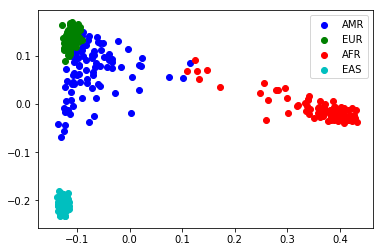

In [41]:
scatter(tab_merge)

In [42]:
from mpl_toolkits.mplot3d import Axes3D

In [43]:
def scatter3d(table, phenotype='Super_Population'):
    """Scatter the result of a PCA.
    Input:
    - table: pd.DataFrame with n rows (ie the number of points/samples)
    - phenotype : phenotype present in the table
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for pop in (table[phenotype].unique()): 
        PCA1 = []
        PCA2 = []
        PCA3 = []
        for i in (table[table[phenotype]==pop].index):
            PCA1.append(table.scores[i][0:3][0])
            PCA2.append(table.scores[i][0:3][1])
            PCA3.append(table.scores[i][0:3][2])
        ax.scatter(PCA1,PCA2, PCA3, label=pop)

    plt.legend()
   


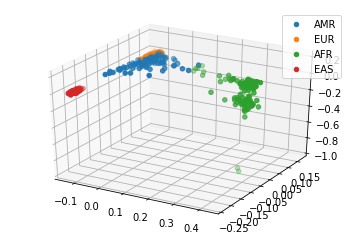

In [44]:
scatter3d(tab_merge)